<a href="https://colab.research.google.com/github/thisisindrajit/DRDetect/blob/main/DR_best_model_ResNet152V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports and initializations

In [ ]:
import numpy as np
import pandas as pd
import imageio
import PIL #pillow
from PIL import Image
import cv2
import tensorflow as tf
import keras
import scipy
import os
import sys
import shutil
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold

from keras import models, layers, optimizers, regularizers
from keras.layers import Dense,Dropout
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.models import load_model
from keras import backend as K

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score

## Variables

In [ ]:
dataset_dir = "/content/drive/MyDrive/Sem 7/Project/Dataset/APTOS-DDR-256-bengraham/"
train_dir = dataset_dir + "train_images/"

batch_size = 16
num_classes = 5

train_csv = pd.read_csv(dataset_dir + "train.csv")

In [ ]:
train_csv

,path,output
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0
...,...,...
3657,ffa47f6a7bf4.png,2
3658,ffc04fed30e6.png,0
3659,ffcf7b45f213.png,2
3660,ffd97f8cd5aa.png,0


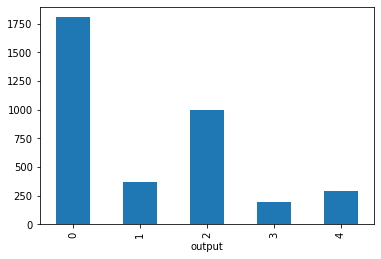

In [ ]:
train_csv.groupby("output").size().plot(kind = "bar")

# Image pre-processing

## Preprocessing APTOS 19 dataset

### Ben graham's preprocessing method

[Reference](https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy#2.-Try-Ben-Graham's-preprocessing-method.)

In [ ]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    
    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking
    
    :return: A NumPy array containing the cropped image
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    
    :param img: A NumPy Array that will be cropped
    :param sigmaX: Value used for add GaussianBlur to the image
    
    :return: A NumPy array containing the preprocessed image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (256, 256))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

### Training set preprocessing

In [ ]:
for i in range(len(train_csv)):

  try:
    file_name = train_csv["path"][i]
    output = train_csv["output"][i]
    file_path = train_dir + str(output) + '/' + file_name
    file_path_op = "/content/drive/MyDrive/Sem 7/Project/Dataset/APTOS-DDR-256-bengraham/train_images/" + str(output) + '/' + file_name

    img = cv2.imread(file_path)[:,:,::-1]

    final_img = preprocess_image(img)

    # f, axarr = plt.subplots(1,2,figsize = (12, 8))
    # axarr[0].imshow(img)
    # axarr[1].imshow(final_img)

    cv2.imwrite(file_path_op, final_img)

  except:
    continue

### Validation set preprocessing

In [ ]:
for i in range(len(valid_csv)):
#for i in range(1):

  try:
    file_name = valid_csv["path"][i]
    output = valid_csv["output"][i]
    file_path = valid_dir + str(output) + '/' + file_name
    file_path_op = "/content/drive/MyDrive/Sem 7/Project/Dataset/APTOS-DDR-256-bengraham/valid_images/" + str(output) + '/' + file_name

    img = cv2.imread(file_path)[:,:,::-1]

    final_img = preprocess_image(img)

    # f, axarr = plt.subplots(1,2,figsize = (12, 8))
    # axarr[0].imshow(img)
    # axarr[1].imshow(final_img)

    cv2.imwrite(file_path_op, final_img)

  except:
    continue

# Loading data using Keras utility

## Using ImageDataGenerator for data augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.3)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

## Loading training and validation dataset

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                               target_size=(256,256), 
                                               batch_size=batch_size, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training') 

validation_generator = test_datagen.flow_from_directory(train_dir, 
                                           target_size=(256,256), 
                                           batch_size=batch_size, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           subset = 'validation')

Found 2557 images belonging to 5 classes.
Found 1091 images belonging to 5 classes.


In [ ]:
counter = Counter(train_generator.classes)

print(counter.items())

dict_items([(0, 1258), (1, 259), (2, 697), (3, 136), (4, 207)])


In [ ]:
counter = Counter(validation_generator.classes)

print(counter.items())

dict_items([(0, 538), (1, 110), (2, 298), (3, 57), (4, 88)])


# Handling imbalanced data

## Generating weight class

In [ ]:
labels_count = dict()
counter = Counter(train_generator.classes)

# taking only labels from 0 to 4
for img_class in range(5):  
    # labels_count[img_class] = len(train_csv[train_csv['output'] == img_class])
    labels_count[img_class] = counter[img_class]

print(labels_count)

total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in 
                 enumerate(labels_count.values())}

print(class_weights)

{0: 1258, 1: 259, 2: 697, 3: 136, 4: 207}
{0: 2.0325914149443562, 1: 9.872586872586872, 2: 3.66857962697274, 3: 18.801470588235293, 4: 12.352657004830919}


# Training Transfer Learning Model (ResNet152V2)

## Getting the base model

In [ ]:
conv_base =  tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

234561536/234545216 [==============================] - 6s 0us/step


## Creating the model

**Global Average pooling 2D**

Global average pooling block is an alternative to the Flattening block after the last pooling block of a convolutional neural network. Using 2D Global average pooling block can replace the fully connected blocks of a CNN.

[Reference](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/blocks/global-average-pooling-2d)

In [ ]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 4
Number of trainable weights after freezing the conv base: 4


In [ ]:
model = models.Sequential()

model.add(conv_base)

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256,activation=('relu'),kernel_regularizer=regularizers.l2(0.001))) 

model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
learn_rate=.0001

adam = tf.keras.optimizers.Adam(learning_rate=learn_rate)

# sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=adam,
      loss='categorical_crossentropy',
      metrics=["accuracy",
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),  
                tf.keras.metrics.AUC(name='auc')])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=12)

rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto', 
                        min_delta=0.0001)

checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Sem 7/Project/models/3-11_ResNet_256*256_CategoricalCrossEntropy_APTOSDDRbengraham.h5', 
                                             monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = False)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 58,857,477
Trainable params: 525,829
Non-trainable params: 58,331,648
_________________________________________________________________


In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=30,
            validation_data=validation_generator,
            validation_steps = validation_generator.samples // batch_size,
            class_weight=class_weights,
            callbacks=[es, rlr, checkpoint])

  # history = model.fit(
  #     aug.flow(X_train, y_train, batch_size=batch_size),
  #     epochs = 10,
  #     validation_data = (X_test, y_test),
  #     verbose = 1,
  #     callbacks=[es, rlr, checkpoint],
  #     class_weight=class_weights)

Epoch 1/30
159/159 [==============================] - 1734s 11s/step - loss: 7.1935 - accuracy: 0.5443 - precision: 0.8113 - recall: 0.3046 - auc: 0.8230 - val_loss: 1.3647 - val_accuracy: 0.6305 - val_precision: 0.8659 - val_recall: 0.4688 - val_auc: 0.8840

Epoch 00001: val_loss improved from inf to 1.36468, saving model to /content/drive/MyDrive/Sem 7/Project/models/3-11_ResNet_256*256_CategoricalCrossEntropy_APTOSDDRbengraham.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
159/159 [==============================] - 89s 562ms/step - loss: 6.1147 - accuracy: 0.6324 - precision: 0.8144 - recall: 0.4506 - auc: 0.8939 - val_loss: 1.2473 - val_accuracy: 0.6645 - val_precision: 0.8722 - val_recall: 0.4706 - val_auc: 0.9129

Epoch 00002: val_loss improved from 1.36468 to 1.24728, saving model to /content/drive/MyDrive/Sem 7/Project/models/3-11_ResNet_256*256_CategoricalCrossEntropy_APTOSDDRbengraham.h5
Epoch 3/30
159/159 [==============================] - 89s 560ms/step - loss: 5.7914 - accuracy: 0.6470 - precision: 0.7958 - recall: 0.5014 - auc: 0.9052 - val_loss: 1.1603 - val_accuracy: 0.7022 - val_precision: 0.8792 - val_recall: 0.5083 - val_auc: 0.9279

Epoch 00003: val_loss improved from 1.24728 to 1.16034, saving model to /content/drive/MyDrive/Sem 7/Project/models/3-11_ResNet_256*256_CategoricalCrossEntropy_APTOSDDRbengraham.h5
Epoch 4/30
159/159 [==============================] - 89s 560ms/step - loss: 5.5983 - accuracy: 0.6525 - precision: 0.

In [ ]:
from sklearn.metrics import confusion_matrix

Y_val_pred = model.predict(validation_generator)

Y_val_pred_hot = np.argmax(Y_val_pred,axis=1)
Y_val_actual_hot = validation_generator.classes

print(confusion_matrix(Y_val_actual_hot, Y_val_pred_hot, labels=[0, 1, 2, 3, 4]))

[[518  15   4   0   1]
 [ 10  66  26   3   5]
 [  6  40 168  39  45]
 [  3   1  14  23  16]
 [  0   5  24  20  39]]


## Plotting training and validation accuracy and loss

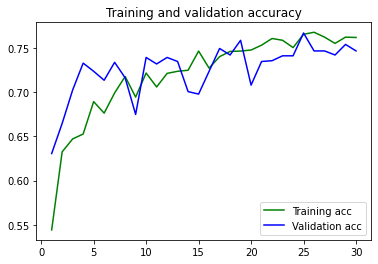

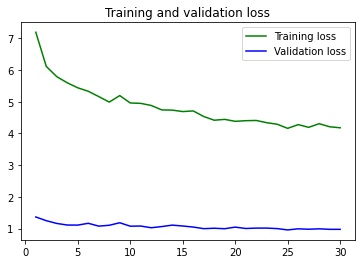

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', color='green', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', color='green', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
print(classification_report(Y_val_actual_hot, Y_val_pred_hot))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       538
           1       0.52      0.60      0.56       110
           2       0.71      0.56      0.63       298
           3       0.27      0.40      0.32        57
           4       0.37      0.44      0.40        88

    accuracy                           0.75      1091
   macro avg       0.57      0.59      0.58      1091
weighted avg       0.77      0.75      0.75      1091



ROC AUC score: 0.7664223531929586


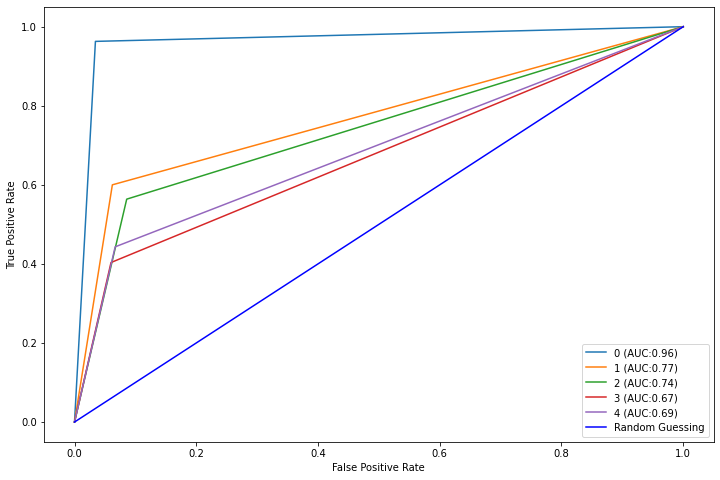

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= [0,1,2,3,4]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

y_test = Y_val_actual_hot
y_pred = Y_val_pred_hot

print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

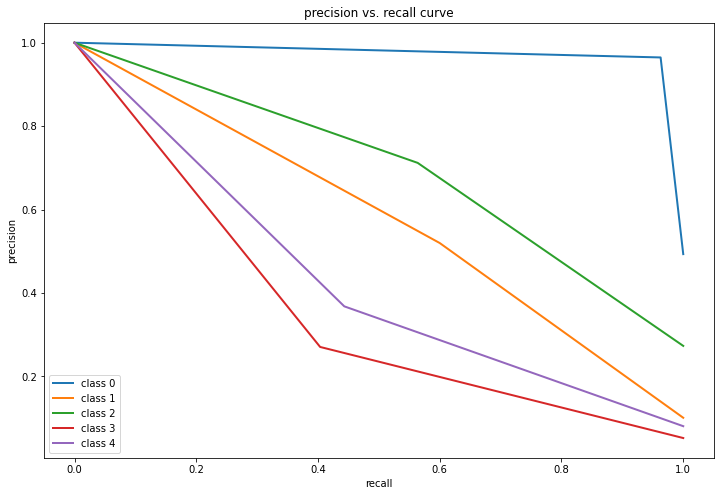

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_curve


target= [0,1,2,3,4]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

y_test = Y_val_actual_hot
y_pred = Y_val_pred_hot

lb = LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)
y_pred = lb.transform(y_pred)

n_classes = 5

precision = dict()
recall = dict()

for i in range(n_classes):
  precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
  plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

In [ ]:
cohen_kappa_score(Y_val_actual_hot, Y_val_pred_hot)

0.6236075545768859

## Saving the model

In [ ]:
model.save("/content/drive/MyDrive/Sem 7/Project/models/3-11_EffNet_256*256_CategoricalCrossEntropy_APTOSDDRbengraham_fullytrained.h5")

# Loading the trained model

In [ ]:
# custom loss function (Focal loss). Reference - https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

def focal_loss(y_true, y_pred):
  gamma = 2.0
  alpha = 0.25
  pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
  pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
  return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [ ]:
# load_model = keras.models.load_model("/content/drive/MyDrive/Sem 7/Project/models/DenseNet_newModel_256*256_TL_focalLoss_AptosDDR.h5",  custom_objects={'focal_loss': focal_loss})
load_model = keras.models.load_model("/content/drive/MyDrive/Sem 7/Project/models/3-11_ResNet_256*256_CategoricalCrossEntropy_APTOSDDRbengraham.h5")

In [ ]:
load_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 58,857,477
Trainable params: 525,829
Non-trainable params: 58,331,648
_________________________________________________________________


In [ ]:
def image_preprocessing(img_path):
    
    image = Image.open(img_path)

    if image.size[0] == image.size[1]:
      resized_image = image.resize((256,256))
    else:
      resized_image = crop_center(image,image.size[1],image.size[1]).resize((256,256))

    return np.asarray(resized_image)

In [ ]:
valid_csv = pd.read_csv("/content/valid_new.csv")
valid_csv

#valid_csv

,path,output
0,31cb39681f6a.png,1
1,61f403fdb434.png,4
2,436fa3fd145a.png,0
3,22895c89792f.png,4
4,8650d32f4a9e.png,0
...,...,...
2184,95e732e043a1.png,4
2185,f451eee2b66b.png,0
2186,753b14c27c83.png,4
2187,b7aca95b97b9.png,0


In [ ]:
for i in range(len(valid_csv)):
    
    try:
      file_name = valid_csv["path"][i]
      output = valid_csv["output"][i]

      img = Image.open(train_dir + str(output) + '/' + file_name)

      target_path = dataset_dir + "valid_new/" + file_name
      img.save(target_path)
    
    except BaseException as err:
      print(err)
      continue

In [ ]:
datagen=ImageDataGenerator(rescale=1./255.)

valid_generator=datagen.flow_from_dataframe(
  valid_csv,
  dataset_dir + "valid_new/",
  x_col="path",
  y_col="output",
  batch_size=batch_size,
  shuffle=False,
  class_mode="raw",
  target_size=(256,256))

Found 2189 validated image filenames.


In [ ]:
Y_val_pred = load_model.predict(valid_generator)

Y_val_pred_hot = np.argmax(Y_val_pred,axis=1)
Y_val_actual_hot = valid_csv[:]["output"]

## Classification Report

In [ ]:
print(classification_report(Y_val_actual_hot, Y_val_pred_hot))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1067
           1       0.63      0.43      0.52       214
           2       0.73      0.73      0.73       614
           3       0.48      0.53      0.51       121
           4       0.48      0.57      0.52       173

    accuracy                           0.80      2189
   macro avg       0.66      0.65      0.65      2189
weighted avg       0.80      0.80      0.80      2189



## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(Y_val_actual_hot, Y_val_pred_hot, labels=[0, 1, 2, 3, 4]))

[[1044   15    6    0    2]
 [  27   93   82    4    8]
 [  18   33  447   45   71]
 [   2    1   27   64   27]
 [   3    5   47   19   99]]


## ROC curves

ROC AUC score: 0.7981001024796035


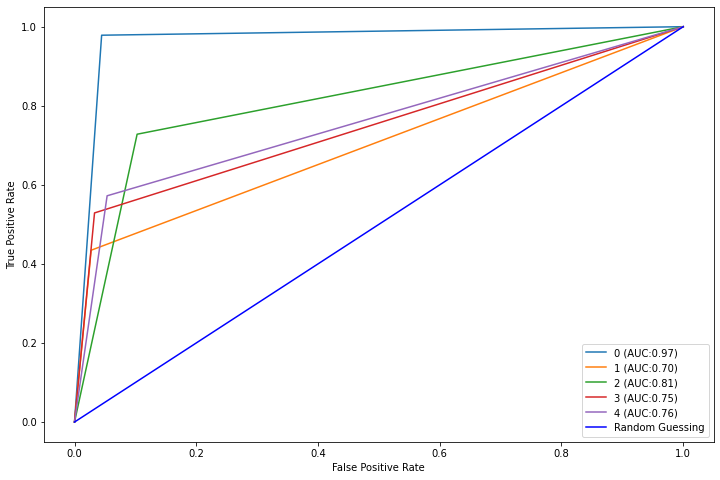

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= [0,1,2,3,4]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(Y_val_actual_hot, Y_val_pred_hot))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

## Precision Recall curves

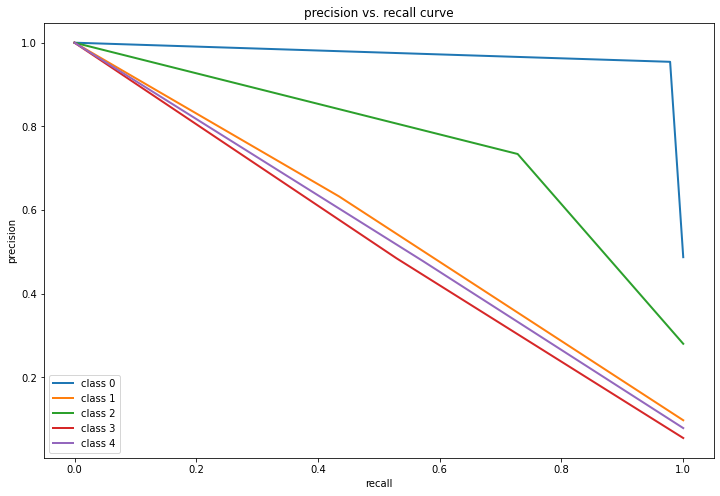

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_curve


target= [0,1,2,3,4]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

y_test = Y_val_actual_hot
y_pred = Y_val_pred_hot

lb = LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)
y_pred = lb.transform(y_pred)

n_classes = 5

precision = dict()
recall = dict()

for i in range(n_classes):
  precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
  plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

## Kappa Score

In [ ]:
cohen_kappa_score(Y_val_actual_hot, Y_val_pred_hot)

0.694518535918789

In [ ]:
img_path = "/content/0ceb222f6629.png"

img = preprocess_image(cv2.imread(img_path)[:,:,::-1])

plt.imshow(img)

np_img = np.asarray(img) / 255.0

expanded_img = np.expand_dims(np_img, axis=0)

y_pred = np.argmax(load_model.predict(expanded_img), axis=1)

print(y_pred)